In [1]:
# Librerie per la manipolazione dei dati
import numpy as np                
import pandas as pd               
import seaborn as sns             
import matplotlib.pyplot as plt    

# Modulo personalizzato per l'ETL
from ETL import ETL                

# Riduzione dimensionale e pre-processing
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

# Algoritmi di clustering
from sklearn.cluster import KMeans, DBSCAN
from sklearn.neighbors import NearestNeighbors

# Metriche di valutazione dei cluster
from sklearn.metrics import silhouette_samples, silhouette_score

# Algoritmi per il numero ottimale di cluster
from kneed import KneeLocator
from yellowbrick.cluster import KElbowVisualizer

In [2]:
df = pd.read_csv('dataset/flights.csv')

In [3]:
df = ETL(df)

# Correlation Analysis

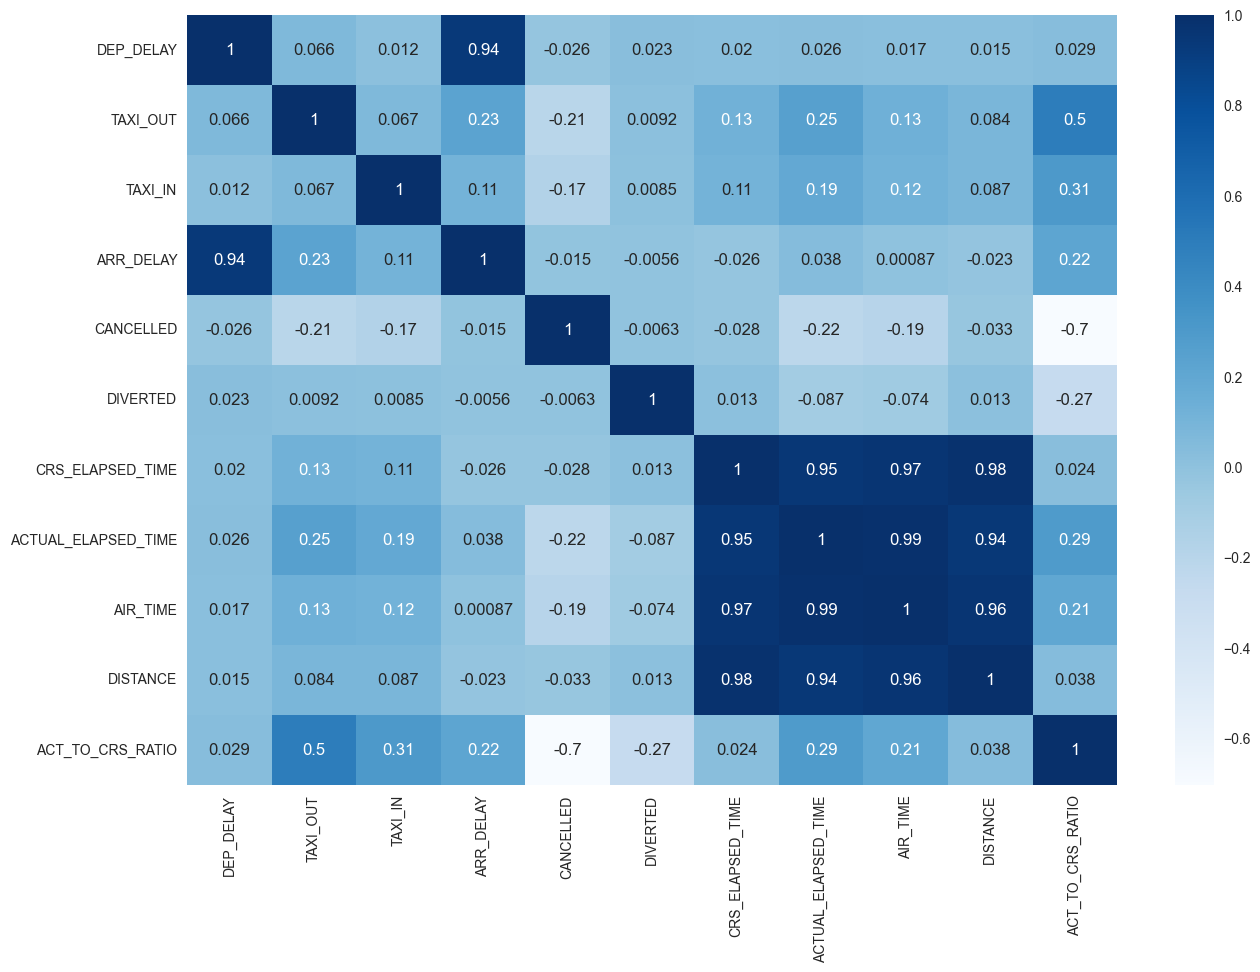

In [5]:
# Creazione e visualizzazione della heatmap per il sottoinsieme selezionato con dimensioni personalizzate della figura
plt.figure(figsize=(15, 10))
heatmap_data = df[[
    'DEP_DELAY',
    'TAXI_OUT',
    'TAXI_IN',
    'ARR_DELAY',
    'CANCELLED',
    'DIVERTED',
    'CRS_ELAPSED_TIME',
    'ACTUAL_ELAPSED_TIME',
    'AIR_TIME',
    'DISTANCE',
    'ACT_TO_CRS_RATIO'
]].corr()
ax = sns.heatmap(
    heatmap_data,
    cmap="Blues",
    annot=True,
    annot_kws={"size": 12}
)  # Visualizza la heatmap con annotazioni
plt.show()


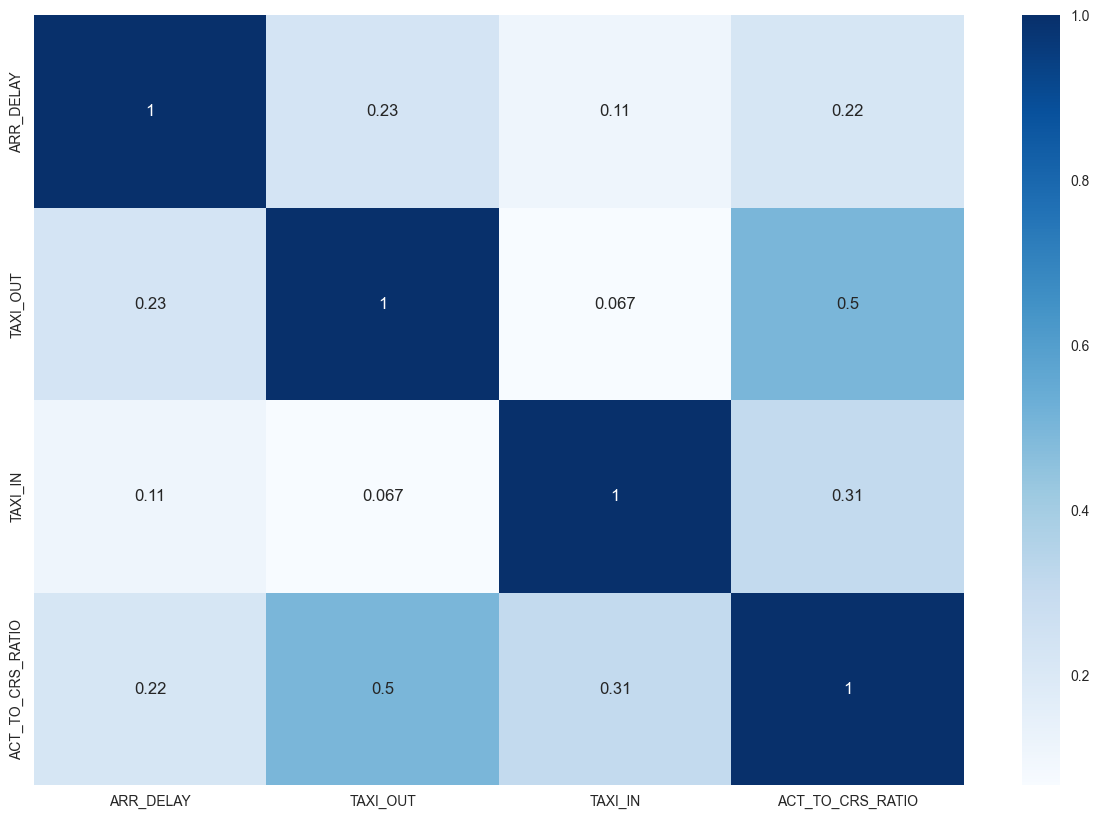

In [61]:
# Creazione e visualizzazione della heatmap per il sottoinsieme selezionato con dimensioni personalizzate della figura
plt.figure(figsize=(15, 10))
heatmap_data = df[['ARR_DELAY', 'TAXI_OUT', 'TAXI_IN', 'ACT_TO_CRS_RATIO']].corr()
ax = sns.heatmap(
    heatmap_data,
    cmap="Blues",
    annot=True,
    annot_kws={"size": 12}
)  # Visualizza la heatmap con annotazioni
plt.show()


# PCA

In [4]:
filtered_data = df
data = df[['ARR_DELAY', 'TAXI_OUT', 
        'TAXI_IN','ACT_TO_CRS_RATIO']]

# Imputazione con la media
data = data.fillna(data.mean())

# Standardizzazione dei dati
scaler = StandardScaler()
data_scaled = scaler.fit_transform(data)

In [5]:
pca = PCA(n_components=2)  # Sostituisci 2 con il numero di componenti che vuoi
pca_result = pca.fit_transform(data_scaled)

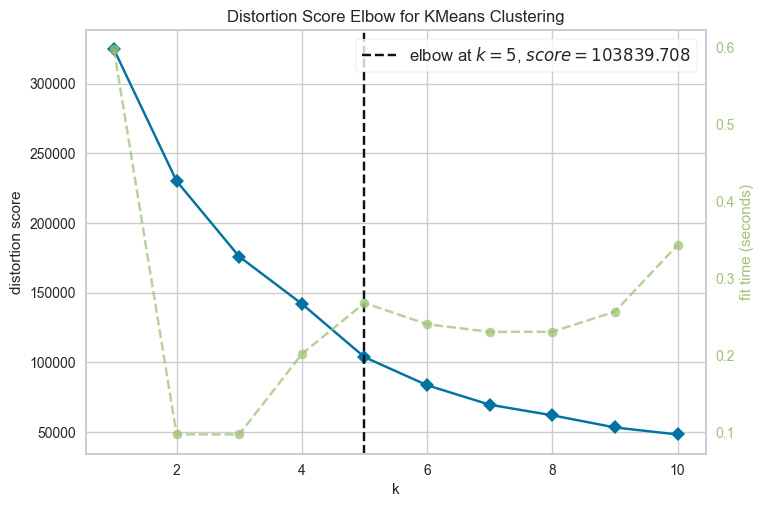

<Axes: title={'center': 'Distortion Score Elbow for KMeans Clustering'}, xlabel='k', ylabel='distortion score'>

In [6]:
# Creazione del modello KMeans
model = KMeans(random_state=42)

# Utilizzo di KElbowVisualizer per determinare il numero ottimale di cluster
visualizer = KElbowVisualizer(model, k=(1, 11), metric='distortion', timings=True)

# Fit dei dati e visualizzazione del grafico
visualizer.fit(pca_result)
visualizer.show()

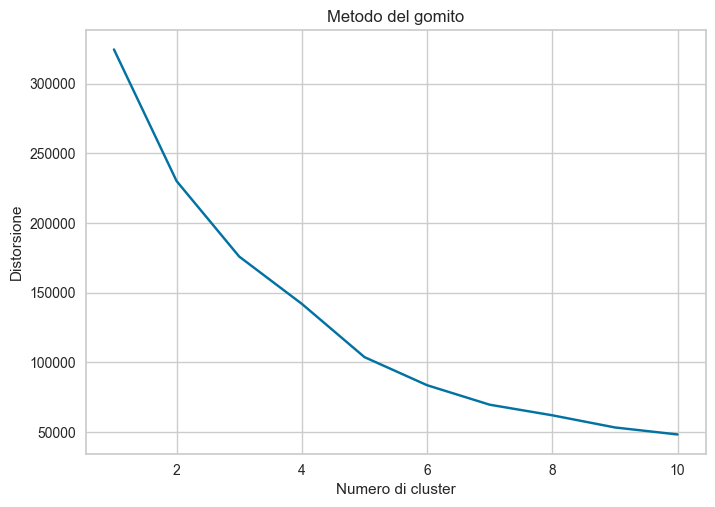

In [7]:
distortions = []
for i in range(1, 11):
    kmeans = KMeans(n_clusters=i, random_state=42)
    kmeans.fit(pca_result)
    distortions.append(kmeans.inertia_)

plt.plot(range(1, 11), distortions)
plt.xlabel('Numero di cluster')
plt.ylabel('Distorsione')
plt.title('Metodo del gomito')
plt.show()

Numero ottimale di cluster secondo il metodo del gomito: 5


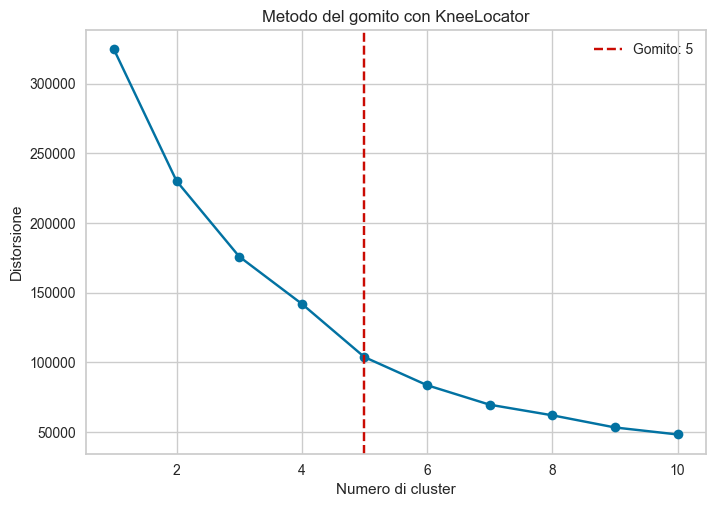

In [8]:
# Calcolare il "gomito"
knee = KneeLocator(range(1, 11), distortions, curve="convex", direction="decreasing")

# Stampare e visualizzare il risultato
print(f"Numero ottimale di cluster secondo il metodo del gomito: {knee.knee}")

# Modificare il grafico per evidenziare il gomito
plt.plot(range(1, 11), distortions, marker='o')
plt.axvline(x=knee.knee, color='r', linestyle='--', label=f"Gomito: {knee.knee}")
plt.xlabel('Numero di cluster')
plt.ylabel('Distorsione')
plt.title('Metodo del gomito con KneeLocator')
plt.legend()
plt.show()


In [9]:
# Applica K-Means ai risultati della PCA
kmeans = KMeans(n_clusters=5, random_state=0)  # Imposta n_clusters al numero desiderato
kmeans.fit(pca_result)
clusters = kmeans.predict(pca_result)
filtered_data['Cluster']= clusters

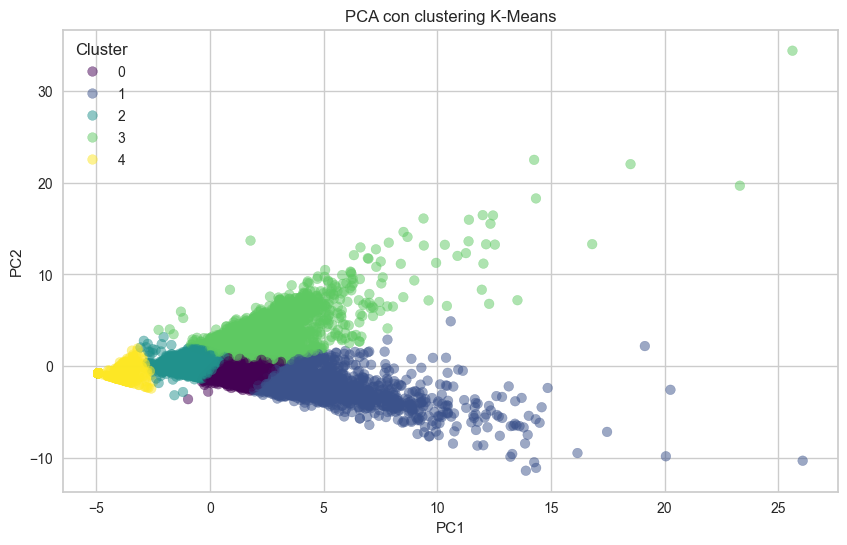

In [68]:
# Visualizza il grafico della PCA con i cluster di K-Means
plt.figure(figsize=(10, 6))
scatter = plt.scatter(pca_result[:, 0], pca_result[:, 1], c=clusters, cmap='viridis', alpha=0.5)
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.title('PCA con clustering K-Means')
plt.legend(*scatter.legend_elements(), title="Cluster", loc='best')
plt.show()

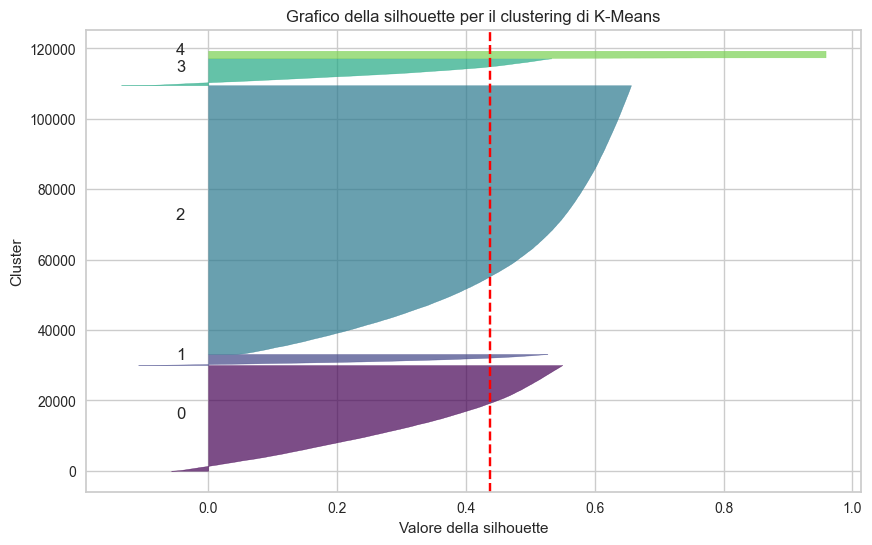

In [75]:
# Calcola i campioni di silhouette per ciascun punto
silhouette_vals = silhouette_samples(pca_result, clusters)

# Calcola la silhouette media per l'intero clustering
silhouette_avg = silhouette_score(pca_result, clusters)

# Visualizza il grafico della silhouette
plt.figure(figsize=(10, 6))
y_lower = 10
n_clusters = len(set(clusters))

for i in range(n_clusters):
    # Accumula i valori di silhouette del cluster i e ordina i valori
    ith_cluster_silhouette_vals = silhouette_vals[clusters == i]
    ith_cluster_silhouette_vals.sort()
    
    y_upper = y_lower + len(ith_cluster_silhouette_vals)
    color = plt.cm.viridis(i / n_clusters)
    
    plt.fill_betweenx(np.arange(y_lower, y_upper),
                      0, ith_cluster_silhouette_vals,
                      facecolor=color, edgecolor=color, alpha=0.7)
    
    # Etichetta ogni silhouette con il rispettivo cluster al centro del grafico
    plt.text(-0.05, y_lower + 0.5 * len(ith_cluster_silhouette_vals), str(i))
    
    # Aggiorna y_lower per il prossimo cluster
    y_lower = y_upper + 10

# Linea verticale per la silhouette media dell'intero clustering
plt.axvline(x=silhouette_avg, color="red", linestyle="--")

plt.xlabel("Valore della silhouette")
plt.ylabel("Cluster")
plt.title("Grafico della silhouette per il clustering di K-Means")
plt.show()

In [11]:
# Crea la colonna 'ROUTE' combinando 'ORIGIN' e 'DEST'
filtered_data['ROUTE'] = filtered_data['ORIGIN'] + '-' + filtered_data['DEST']

# Calcola il totale dei voli e la percentuale per cluster
total_flights = len(data)
cluster_counts = filtered_data['Cluster'].value_counts().sort_index()
cluster_percentages = (cluster_counts / total_flights) * 100

# Funzione per calcolare i ritardi e le statistiche
def calculate_delays_and_stats(cluster_data, total_cluster_flights):
    # Calcolo dei voli cancellati e dirottati
    cancelled = (cluster_data['CANCELLED'] == 1).sum()
    diverted = (cluster_data['DIVERTED'] == 1).sum()

    # Calcola i ritardi per i voli non cancellati né dirottati
    non_cancelled_diverted_data = cluster_data[(cluster_data['CANCELLED'] == 0) & (cluster_data['DIVERTED'] == 0)]
    arr_delay = non_cancelled_diverted_data['ARR_DELAY']

    # Calcolo ritardi per intervalli specifici
    arr_delay_count = {
        'ARR_DELAY < -5': (arr_delay < -5).sum(),
        '-5 < ARR_DELAY <= 5': ((arr_delay >= -5) & (arr_delay <= 5)).sum(),
        '5 < ARR_DELAY <= 15': ((arr_delay > 5) & (arr_delay <= 15)).sum(),
        '15 < ARR_DELAY <= 60': ((arr_delay > 15) & (arr_delay <= 60)).sum(),
        '60 < ARR_DELAY': (arr_delay > 60).sum(),
    }

    # Calcolo della media dei ritardi
    arr_delay_avg = arr_delay.mean() if len(arr_delay) > 0 else 0

    # Calcola statistiche taxi
    non_cancelled_data = cluster_data[cluster_data['DIVERTED'] == 0]
    act_to_crs_ratio_mean = cluster_data['ACT_TO_CRS_RATIO'].mean()
    act_to_crs_ratio_std = cluster_data['ACT_TO_CRS_RATIO'].std()
    taxi_in_mean, taxi_in_std = non_cancelled_data['TAXI_IN'].mean(), non_cancelled_data['TAXI_IN'].std()
    taxi_out_mean, taxi_out_std = non_cancelled_data['TAXI_OUT'].mean(), non_cancelled_data['TAXI_OUT'].std()

    return {
        'Cancelled == 1': (cancelled / total_cluster_flights) * 100,
        'Diverted == 1': (diverted / total_cluster_flights) * 100,
        'AVERAGE ARR_DELAY': arr_delay_avg,
        **{key: (value / total_cluster_flights) * 100 for key, value in arr_delay_count.items()},
        'AVERAGE ACT_TO_CRS_RATIO': act_to_crs_ratio_mean,
        'STD ACT_TO_CRS_RATIO': act_to_crs_ratio_std,
        'AVERAGE TAXI_OUT': taxi_out_mean,
        'STD TAXI_OUT': taxi_out_std,
        'AVERAGE TAXI_IN': taxi_in_mean,
        'STD TAXI_IN': taxi_in_std,
    }

# Calcola i risultati per ogni cluster
results = []
for cluster in cluster_counts.index:
    cluster_data = filtered_data[filtered_data['Cluster'] == cluster]
    
    # Calcola la ROUTE e OP_CARRIER più frequenti per ogni cluster
    route = cluster_data['ROUTE'].mode().iloc[0]
    op_carrier = cluster_data['OP_CARRIER'].mode().iloc[0]

    # Aggiungi i risultati al dizionario
    results.append({
        'Cluster': cluster,
        'Percent Flights': cluster_percentages[cluster],
        **calculate_delays_and_stats(cluster_data, len(cluster_data)),
        'ROUTE': route,
        'OP_CARRIER': op_carrier,
    })

# Crea il dataframe dei risultati
results_df = pd.DataFrame(results)

# Visualizza i risultati
results_df

,Cluster,Percent Flights,Cancelled == 1,Diverted == 1,AVERAGE ARR_DELAY,ARR_DELAY < -5,-5 < ARR_DELAY <= 5,5 < ARR_DELAY <= 15,15 < ARR_DELAY <= 60,60 < ARR_DELAY,AVERAGE ACT_TO_CRS_RATIO,STD ACT_TO_CRS_RATIO,AVERAGE TAXI_OUT,STD TAXI_OUT,AVERAGE TAXI_IN,STD TAXI_IN,ROUTE,OP_CARRIER
0,0,25.162864,0.003332,0.009996,22.985604,12.315074,30.634413,19.185659,24.127016,13.724510,1.028847,0.088447,22.180712,7.347197,6.456896,2.899639,SFO-LAX,DL
1,1,2.634337,0.000000,0.000000,107.511776,0.254615,1.113940,5.856143,42.775302,50.000000,1.260057,0.267492,48.087842,22.503498,7.454488,4.654404,LGA-ATL,DL
2,2,64.001308,0.001310,0.043230,-7.580490,65.008188,22.386847,6.052270,6.085020,0.423135,0.922668,0.069770,12.298380,3.753876,5.954117,2.653081,LAX-SFO,WN
3,3,6.398035,0.000000,0.091731,10.103358,24.859127,32.027257,18.398637,19.289739,5.333508,1.054811,0.128784,14.824239,6.160971,21.582371,10.207979,SFO-LAX,AA
4,4,1.803456,88.331009,11.576011,-42.000000,0.092980,0.000000,0.000000,0.000000,0.000000,0.000415,0.013657,0.190852,1.871141,0.004206,0.133670,LGA-ORD,WN


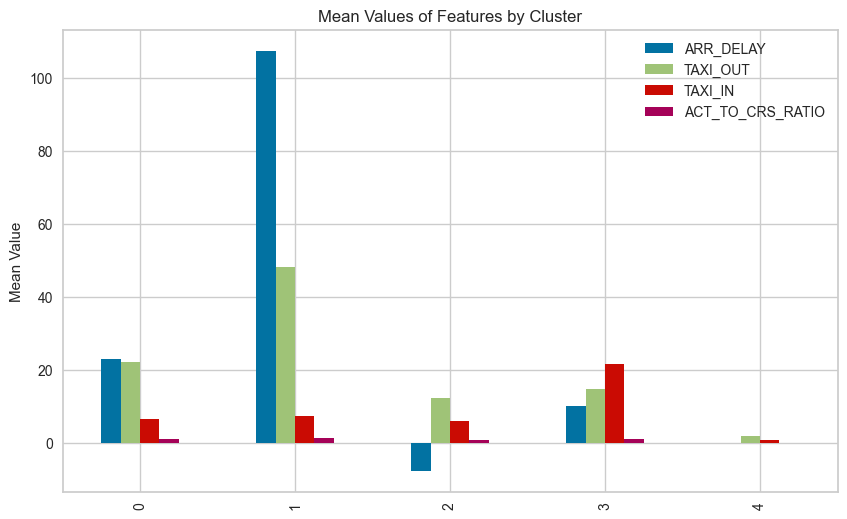

In [12]:
cluster_means = data.groupby(kmeans.labels_).mean()
cluster_means.plot(kind='bar', figsize=(10, 6))
plt.title('Mean Values of Features by Cluster')
plt.ylabel('Mean Value')
plt.show()


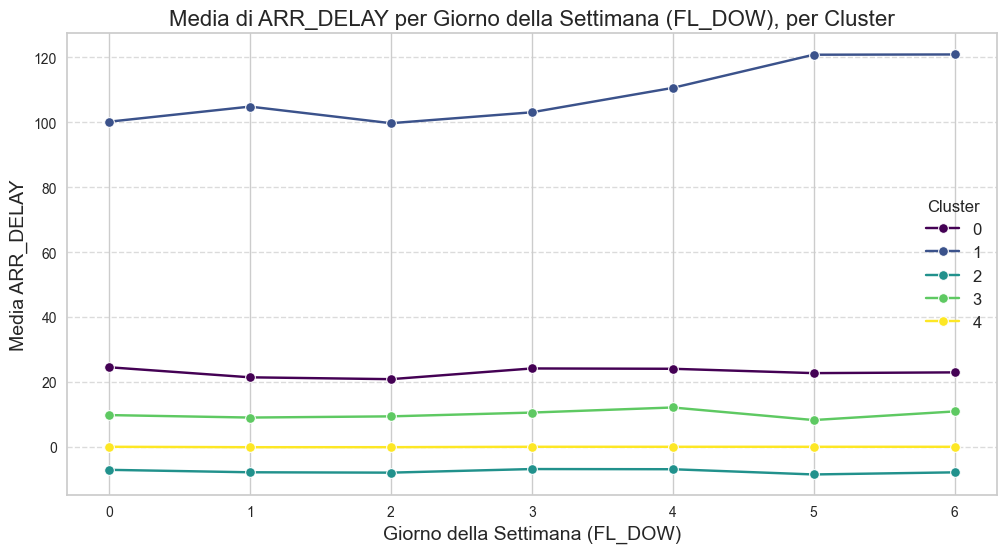

In [69]:
# Calcola la media e la deviazione standard per ARR_DELAY per cluster e FL_DOW
grouped_data = filtered_data.groupby(['FL_DOW', 'Cluster'])['ARR_DELAY'].agg(['mean', 'std']).reset_index()

# Crea il grafico lineplot
plt.figure(figsize=(12, 6))
sns.lineplot(
    data=grouped_data,
    x='FL_DOW',
    y='mean',
    hue='Cluster',
    marker='o',
    palette='viridis',
    err_style="bars",  # Visualizza le barre di errore
    err_kws={'capsize': 5}  # Dimensione dei "tappi" delle barre di errore
)

# Aggiungi titolo e etichette
plt.title('Media di ARR_DELAY per Giorno della Settimana (FL_DOW), per Cluster', fontsize=16)
plt.xlabel('Giorno della Settimana (FL_DOW)', fontsize=14)
plt.ylabel('Media ARR_DELAY', fontsize=14)
plt.legend(title='Cluster', fontsize=12)
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Mostra il grafico
plt.show()

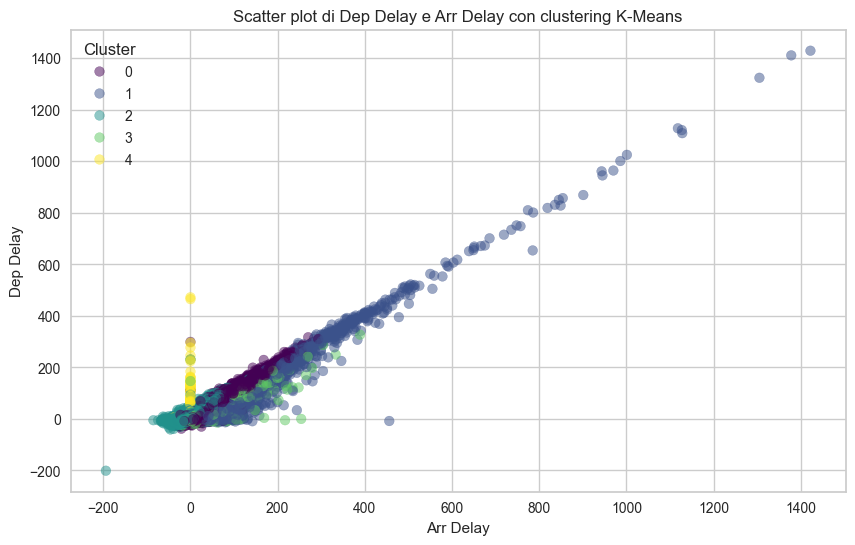

In [13]:
# Visualizza il grafico scatter di dep_delay e arr_delay con i cluster di K-Means
plt.figure(figsize=(10, 6))
scatter = plt.scatter(filtered_data['ARR_DELAY'], filtered_data['DEP_DELAY'], c=clusters, cmap='viridis', alpha=0.5)
plt.xlabel('Arr Delay')
plt.ylabel('Dep Delay')
plt.title('Scatter plot di Dep Delay e Arr Delay con clustering K-Means')

# Aggiungi una legenda per i cluster
plt.legend(*scatter.legend_elements(), title="Cluster")
plt.show()

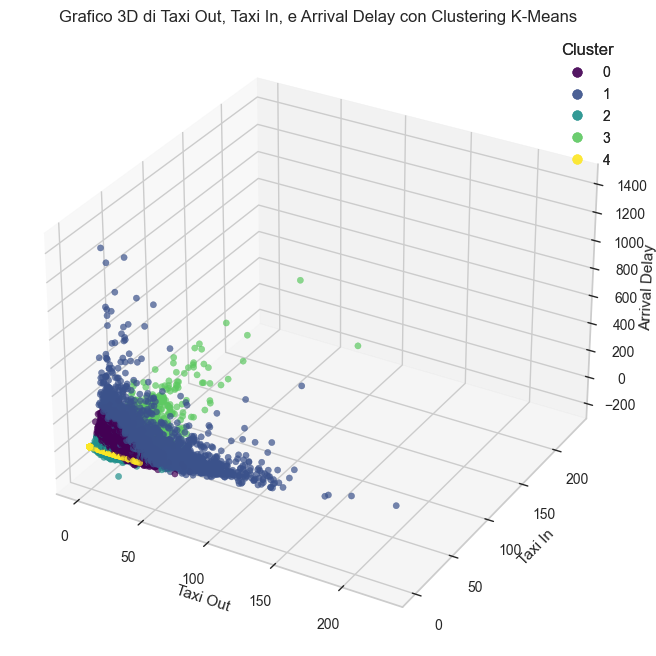

In [14]:
# Creazione della figura 3D
fig = plt.figure(figsize=(12, 8))
ax = fig.add_subplot(111, projection='3d')

# Creazione dello scatter plot 3D
scatter = ax.scatter(
    data['TAXI_OUT'], 
    data['TAXI_IN'], 
    data['ARR_DELAY'], 
    c=clusters, 
    cmap='viridis', 
    alpha=0.7
)

# Etichette degli assi
ax.set_xlabel('Taxi Out')
ax.set_ylabel('Taxi In')
ax.set_zlabel('Arrival Delay')

# Titolo
ax.set_title('Grafico 3D di Taxi Out, Taxi In, e Arrival Delay con Clustering K-Means')

# Legenda
legend = ax.legend(*scatter.legend_elements(), title="Cluster", loc="best")
fig.add_artist(legend)

# Mostra il grafico
plt.show()


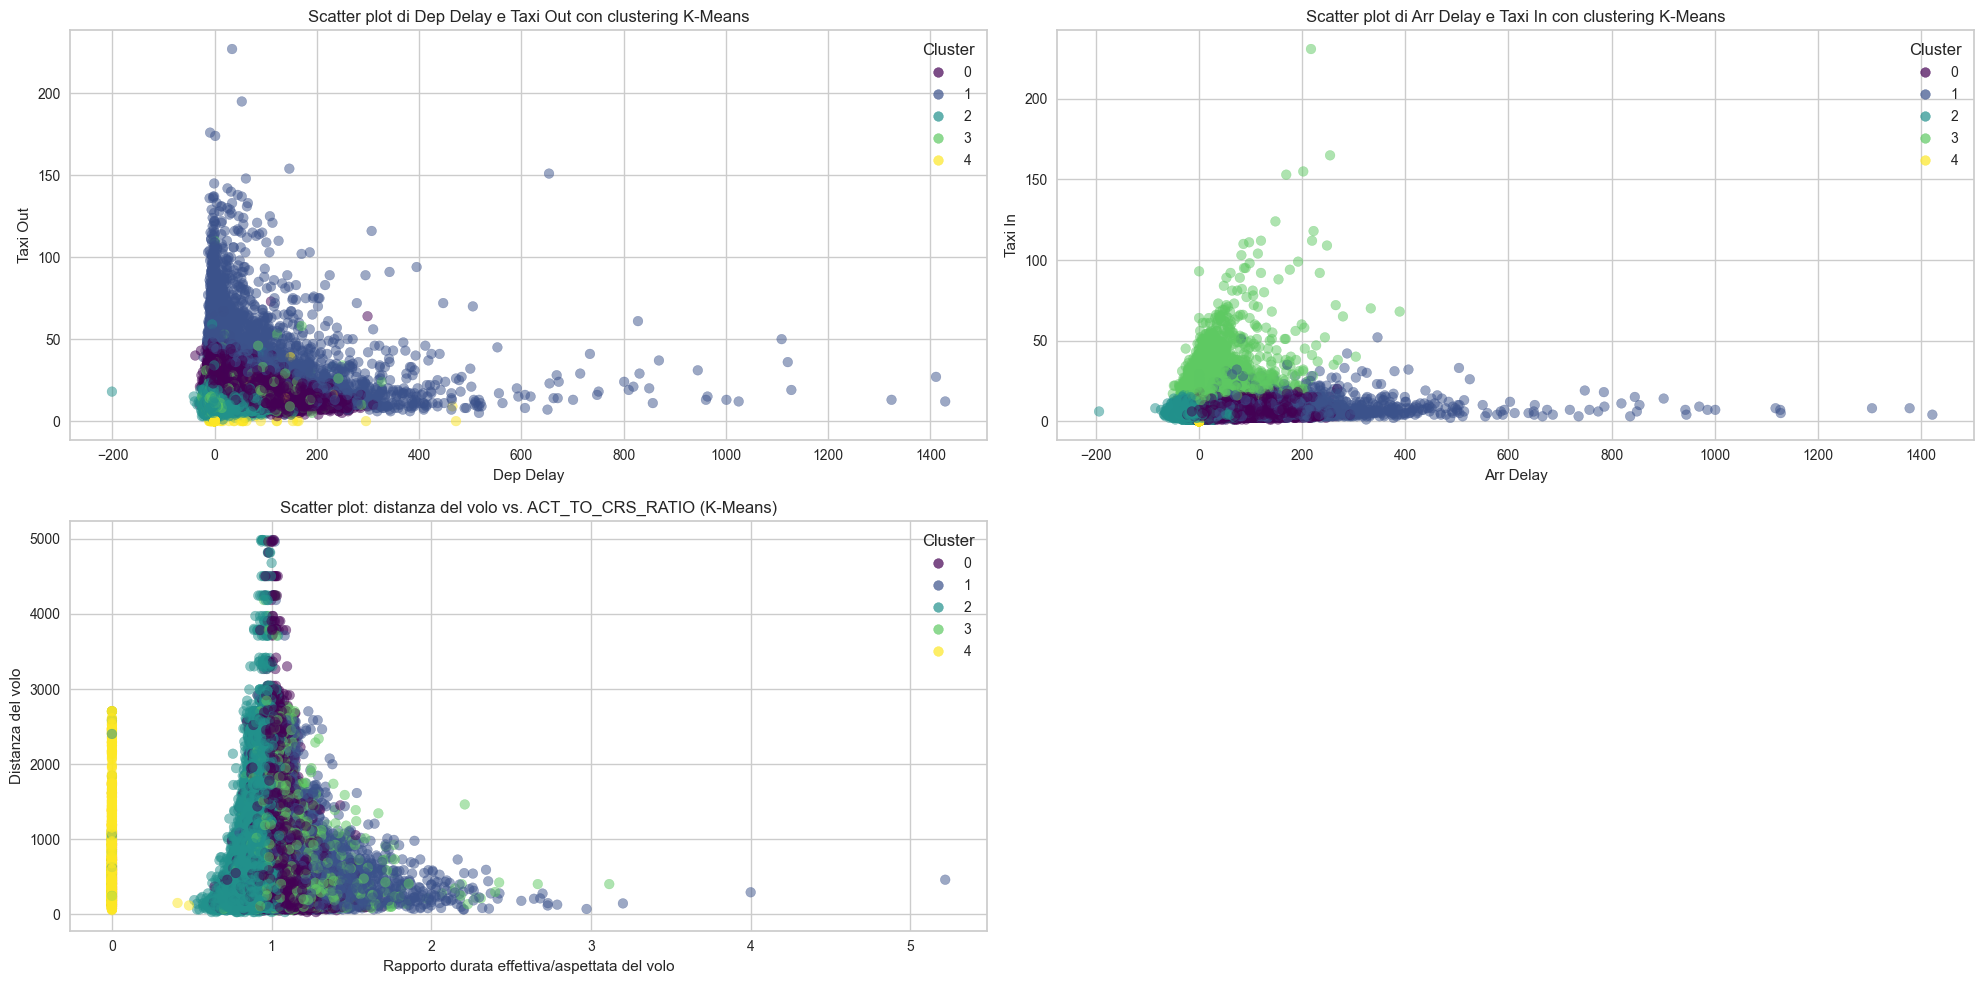

In [15]:
# Creazione della figura con due subplot
plt.figure(figsize=(20, 10))

# Primo grafico
plt.subplot(2, 2, 1)
plt.scatter(filtered_data['DEP_DELAY'], data['TAXI_OUT'], c=clusters, cmap='viridis', alpha=0.5)
plt.xlabel('Dep Delay')
plt.ylabel('Taxi Out')
plt.title('Scatter plot di Dep Delay e Taxi Out con clustering K-Means')
plt.legend(*scatter.legend_elements(), title="Cluster")

# Secondo grafico
plt.subplot(2, 2, 2)
plt.scatter(data['ARR_DELAY'], data['TAXI_IN'], c=clusters, cmap='viridis', alpha=0.5)
plt.xlabel('Arr Delay')
plt.ylabel('Taxi In')
plt.title('Scatter plot di Arr Delay e Taxi In con clustering K-Means')
plt.legend(*scatter.legend_elements(), title="Cluster")

# Terzo grafico
plt.subplot(2, 2, 3)
plt.scatter(data['ACT_TO_CRS_RATIO'], filtered_data['DISTANCE'], c=clusters, cmap='viridis', alpha=0.5)

# Etichette e titolo
plt.xlabel('Rapporto durata effettiva/aspettata del volo')
plt.ylabel('Distanza del volo')
plt.title('Scatter plot: distanza del volo vs. ACT_TO_CRS_RATIO (K-Means)')
plt.legend(*scatter.legend_elements(), title="Cluster")

# Mostra il grafico affiancato
plt.tight_layout()
plt.show()


# DBSCAN

In [4]:
filtered_data = df
data = filtered_data[['ARR_DELAY', 'TAXI_OUT', 
                    'TAXI_IN','ACT_TO_CRS_RATIO']]

# Imputazione con la media
data = data.fillna(data.mean())

# Standardizzazione dei dati
scaler = StandardScaler()
data_scaled = scaler.fit_transform(data)

pca = PCA(n_components=2)  # Sostituisci 2 con il numero di componenti che vuoi
pca_result = pca.fit_transform(data_scaled)

# Calcola le distanze dai vicini più prossimi
k = 5 # Imposta 'k' uguale a min_samples.+-
neigh = NearestNeighbors(n_neighbors=k)
neighbors = neigh.fit(pca_result)
distances, indices = neighbors.kneighbors(pca_result)

# Ordina le distanze in ordine crescente
distances = np.sort(distances[:, 1], axis=0)  # Prendi solo la seconda colonna per la distanza dal 2° vicino

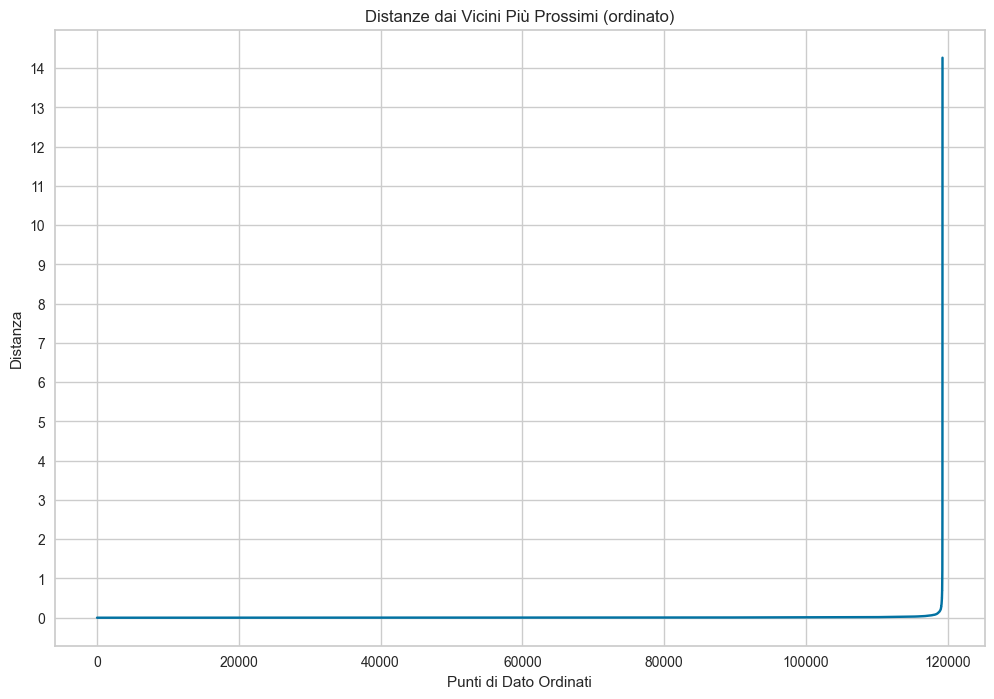

In [5]:
# Traccia il grafico per trovare il valore di epsilon
plt.figure(figsize=(12,8))
plt.plot(distances)
plt.title('Distanze dai Vicini Più Prossimi (ordinato)')
plt.xlabel('Punti di Dato Ordinati')
plt.ylabel('Distanza')
plt.grid(True)

y_ticks = np.arange(0, np.max(distances))
plt.yticks(y_ticks)

plt.show()

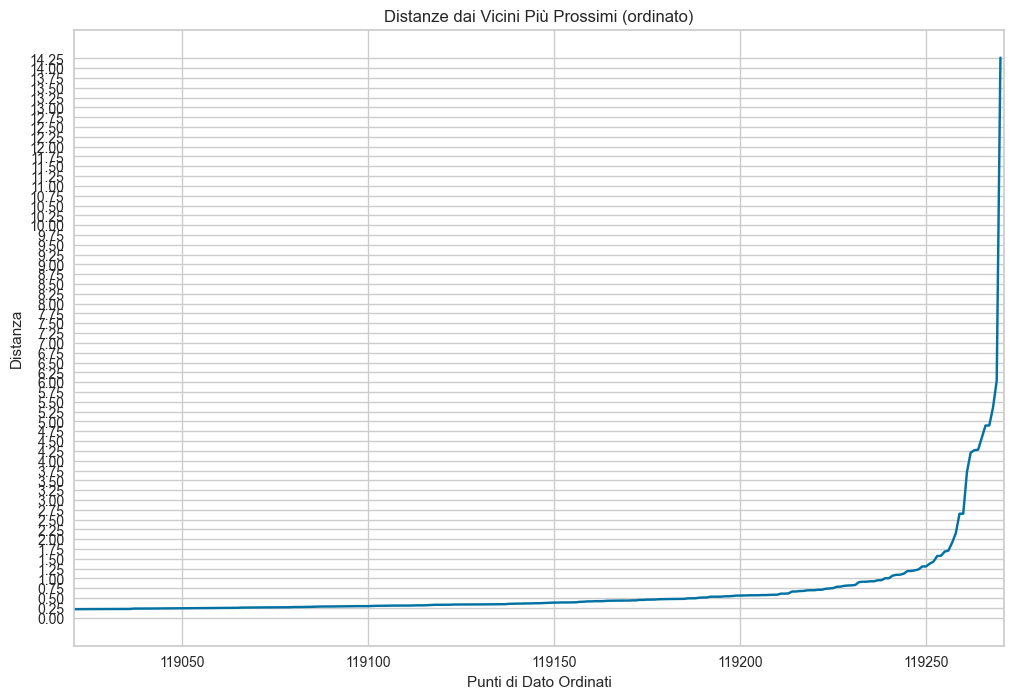

In [6]:
# Traccia il grafico per trovare il valore di epsilon
plt.figure(figsize=(12,8))
plt.plot(distances)
plt.title('Distanze dai Vicini Più Prossimi (ordinato)')
plt.xlabel('Punti di Dato Ordinati')
plt.ylabel('Distanza')
plt.grid(True)

# Aggiungi i tick ogni 0.1 sull'asse y
y_ticks = np.arange(0, np.max(distances), 0.25)  # passo di 0.1
plt.yticks(y_ticks)

# Fai lo zoom negli ultimi 400 punti sull'asse delle x
plt.xlim(len(distances)-250, len(distances))  # zoom sugli ultimi 400 punti

plt.show()


In [7]:
# Calcola la differenza tra i valori consecutivi (prima derivata)
delta_distances = np.diff(distances)

# Calcola la differenza tra le variazioni consecutive (seconda derivata)
delta_delta_distances = np.diff(delta_distances)

# Trova l'indice in cui la variazione della variazione è massima
epsilon_index = np.argmax(np.abs(delta_delta_distances)) + 1  # +1 per allineare l'indice originale

# Epsilon è il valore della distanza al punto del massimo cambiamento
epsilon = distances[epsilon_index]
print(f"Epsilon calcolato: {epsilon}")

Epsilon calcolato: 6.035818004460897


In [8]:
#distanze normali

kneedle = KneeLocator(range(len(distances)), distances, curve="convex", direction="increasing")

# Epsilon è il valore della distanza al punto del ginocchio
epsilon = distances[kneedle.elbow]
print(f"Epsilon calcolato: {epsilon}")

Epsilon calcolato: 0.5351285193746583


In [9]:
#distanze smussate

# Esegui una media mobile per smussare i dati
window_size = 2  # ad esempio, 50 punti
smoothed_distances = np.convolve(distances, np.ones(window_size)/window_size, mode='valid')

kneedle = KneeLocator(range(len(smoothed_distances)), smoothed_distances, curve="convex", direction="increasing")

# Epsilon è il valore della distanza al punto del ginocchio
epsilon = distances[kneedle.elbow]
print(f"Epsilon calcolato: {epsilon}")

Epsilon calcolato: 0.24793409487924975


In [10]:
# Esegui DBSCAN sui risultati della PCA
dbscan = DBSCAN(eps=epsilon, min_samples=k)  # Imposta eps e min_samples in base ai tuoi dati
dbscan_labels = dbscan.fit_predict(pca_result)

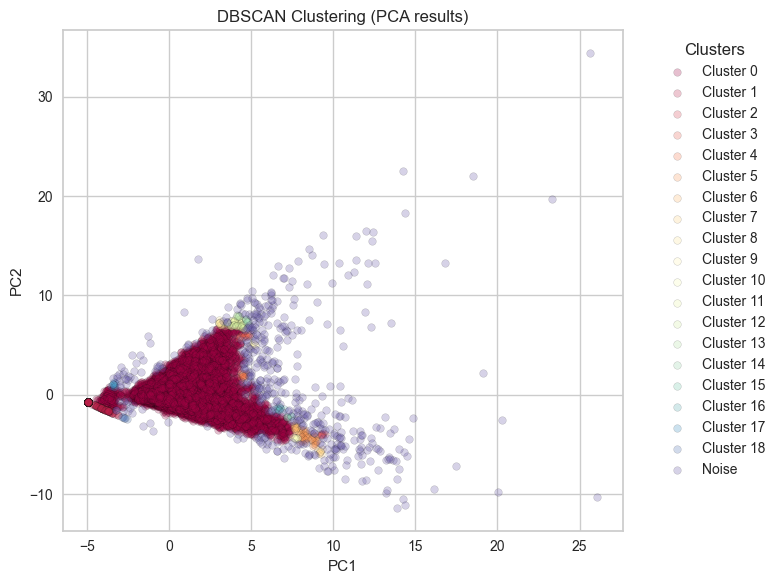

In [11]:
# Crea un grafico dei dati dopo l'applicazione della PCA
plt.figure(figsize=(8, 6))

# DBSCAN assegna -1 ai punti considerati "rumore"
unique_labels = set(dbscan_labels)
colors = [plt.cm.Spectral(each) for each in np.linspace(0, 1, len(unique_labels))]

for i, col in zip(unique_labels, colors):
    class_member_mask = (dbscan_labels == i)
    xy = pca_result[class_member_mask]
    
    plt.scatter(xy[:, 0], xy[:, 1], s=30, c=[col], label=f"Cluster {i}" if i != -1 else 'Noise', edgecolors='k', alpha=0.25)

plt.title('DBSCAN Clustering (PCA results)')
plt.xlabel('PC1')
plt.ylabel('PC2')

# Aggiusta la posizione e la dimensione della legenda per migliorarne la leggibilità
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', fontsize=10, title="Clusters")

plt.tight_layout()  # Per evitare che la legenda si sovrapponga
plt.show()
